# Семинар 4: "Методы оптимизации"

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем сравнить различные методы оптимизации.

На семинаре реализуем и сравним методы:
<b>SGD, NAG, Adagrad, RMSProp</b>.



## Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

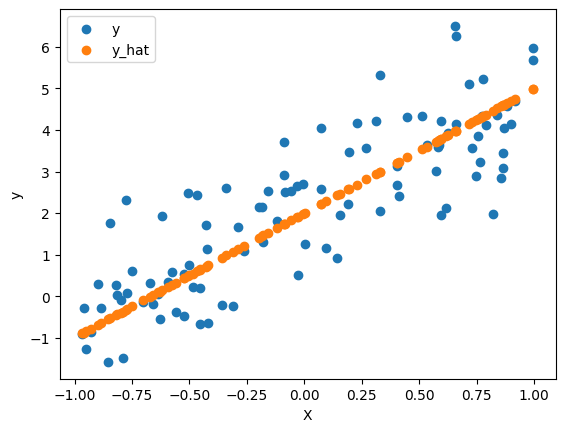

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

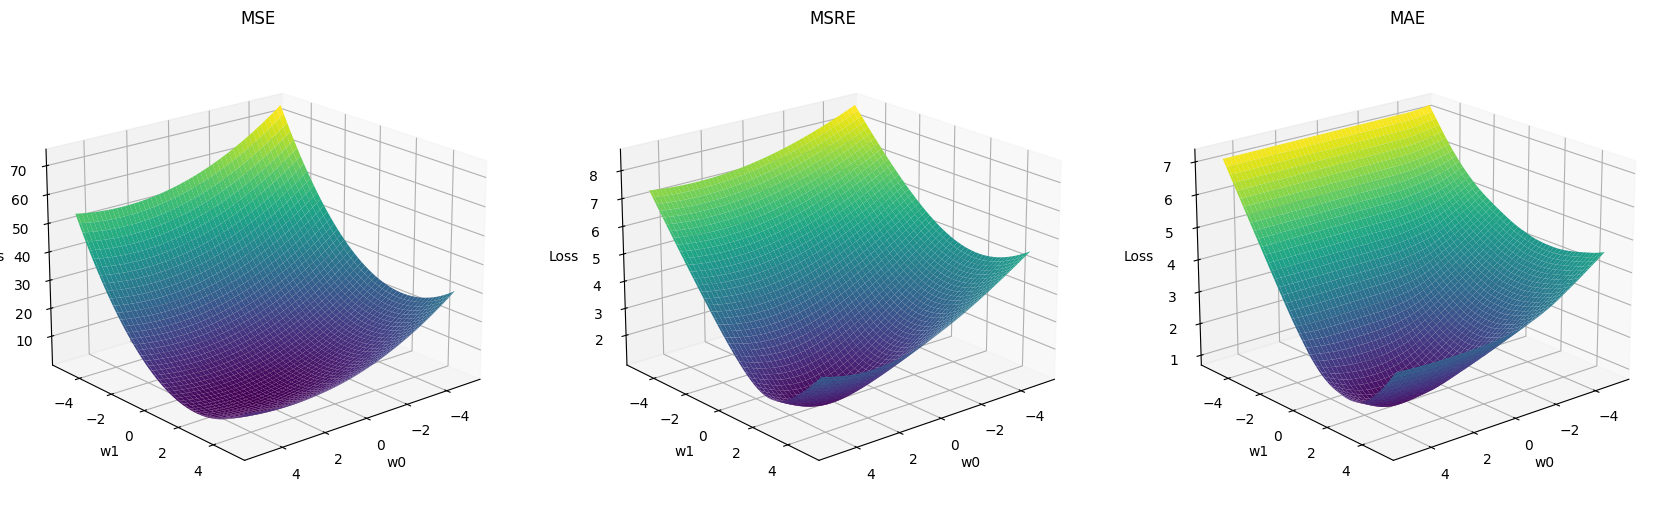

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

<i> 1.1 Реализуем методы SGD, NAG, Adagrad, RMSProp</i>:

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

### SGD
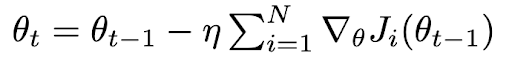

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is not None:
                    p -= self.lr * p.grad


### Nesterov accelerated gradient
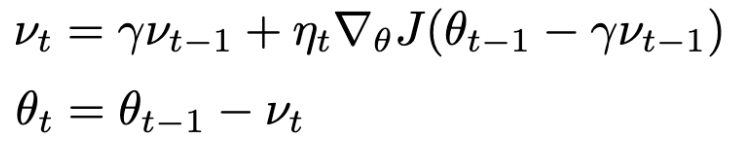

In [9]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.momentum = [torch.zeros(p.shape).to(p.device) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    prev_momentum = self.momentum[i]
                    self.momentum[i] = self.gamma * prev_momentum + self.lr * p.grad
                    p -= (1 + self.gamma) * self.momentum[i] - self.gamma * prev_momentum


### AdaGrad
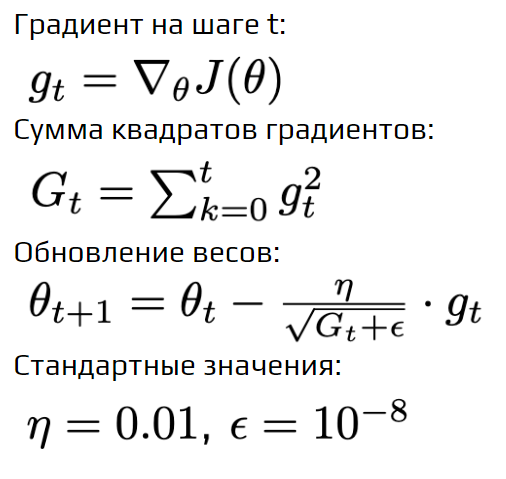

In [10]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)

        self.eta = eta
        self.epsilon = epsilon

        self.G = [torch.zeros(p.shape).to(p.device) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    self.G[i] += p.grad ** 2
                    p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

### RMSProp

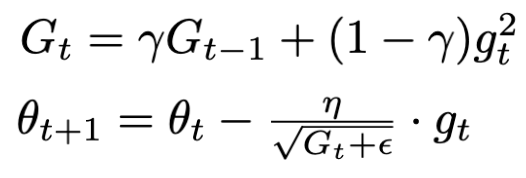

In [11]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)

        self.epsilon = epsilon
        self.eta = eta
        self.gamma = gamma

        self.G = [torch.zeros(p.shape).to(p.device) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)

                    p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad



In [12]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), AdaGrad, {'eta': 1e-8}, start_point=[-4, -4], num_iter=100)

In [13]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta': 1}],
        ['RMSProp', RMSProp, {'eta': 1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

В качестве домашней работы вам необходимо будет реализовать и сравнить методы:
<b>Momentum, AdaDelta, Adam</b>.

Также вам будет предложено сравнить реализованные методы при обучении полносвязной и сверточной нейронных сетей на датасете MNIST.



In [12]:
class Momentun(Optimizer):
    def __init__(self, params, lr=1e-1, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.momentum = [torch.zeros(p.shape).to(p.device) for p in self.params]
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:
                    self.momentum[i] = self.gamma * self.momentum[i] + self.lr * p.grad
                    p -= self.momentum[i]

In [13]:
class AdaDelta(Optimizer):
    def __init__(self, params, lr=1.0, rho=0.9, eps=1e-6):
        super().__init__(params)
        self.rho = rho
        self.eps = eps
        self.lr = lr

        self.thets = [torch.zeros(p.shape).to(p.device) for p in self.params]
        self.s = [torch.zeros(p.shape).to(p.device) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:
                    self.s[i] = self.rho * self.s[i] + (1 - self.rho) * (p.grad ** 2)
                    delta = torch.sqrt(self.thets[i] + self.eps) / torch.sqrt(self.s[i] + self.eps) * p.grad
                    self.thets[i] = self.rho * self.thets[i] + (1 - self.rho) * (delta ** 2)
                    p -= self.lr * delta

In [14]:
class Adam(Optimizer):
    def __init__(self, params, beta1=0.999, beta2=0.9, lr=1e-2, eps=1e-6):
        super().__init__(params)
        self.beta1 = beta1
        self.beta2 = beta2
        self.lr = lr
        self.eps = eps

        self.momentums = [torch.zeros(p.shape).to(p.device) for p in self.params]
        self.thetas = [torch.zeros(p.shape).to(p.device) for p in self.params]

        self.steps = 1

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    self.thetas[i] = self.beta1 * self.thetas[i] + (1 - self.beta1) * p.grad ** 2
                    self.momentums[i] = self.beta2 * self.momentums[i] + (1 - self.beta2) * p.grad

                    curr_thet = self.thetas[i] / (1 - self.beta1 ** self.steps)
                    curr_momentum = self.momentums[i] / (1 - self.beta2 ** self.steps)

                    p -= self.lr * curr_momentum / (torch.sqrt(curr_thet) + self.eps)
            self.steps += 1


In [17]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta': 1}],
        ['RMSProp', RMSProp, {'eta': 1}],
        ['Momentun', Momentun, {'lr': 1e-1}],
        ['AdaDelta', AdaDelta, {"lr":10.0}],
        ['Adam', Adam, {"lr":1e-1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

MNIST

In [18]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [19]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [20]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    step_print = len(train_loader) // 10
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % step_print == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (test_loss, correct / len(test_loader.dataset))

In [21]:
batch_size = 256
train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': batch_size}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)


100%|██████████| 9912422/9912422 [00:00<00:00, 134168865.11it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41627386.19it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 46061109.83it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3155628.42it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [22]:
def run_learning(model, optimizer, epochs):
    val_losses = []
    val_accuracy = []
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        val_loc, val_auc = test(model, device, test_loader)
        val_losses.append(val_loc)
        val_accuracy.append(val_auc)
    return val_losses, val_accuracy

In [23]:
num_epochs = 10

In [24]:
model = Net().to(device)
optimizer = SGD(model.parameters(), lr=0.01)
val_losses_sgd, val_accuracy_sgd = run_learning(model, optimizer, num_epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306743
Train Epoch: 1 [5888/60000 (10%)]	Loss: 2.204889
Train Epoch: 1 [11776/60000 (20%)]	Loss: 1.992751
Train Epoch: 1 [17664/60000 (29%)]	Loss: 1.588636
Train Epoch: 1 [23552/60000 (39%)]	Loss: 1.083212
Train Epoch: 1 [29440/60000 (49%)]	Loss: 0.834261
Train Epoch: 1 [35328/60000 (59%)]	Loss: 0.654668
Train Epoch: 1 [41216/60000 (69%)]	Loss: 0.812559
Train Epoch: 1 [47104/60000 (78%)]	Loss: 0.636326
Train Epoch: 1 [52992/60000 (88%)]	Loss: 0.549281
Train Epoch: 1 [58880/60000 (98%)]	Loss: 0.214301

Test set: Average loss: 0.3903, Accuracy: 8798/10000 (88%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.523800
Train Epoch: 2 [5888/60000 (10%)]	Loss: 0.403621
Train Epoch: 2 [11776/60000 (20%)]	Loss: 0.405268
Train Epoch: 2 [17664/60000 (29%)]	Loss: 0.559460
Train Epoch: 2 [23552/60000 (39%)]	Loss: 0.454543
Train Epoch: 2 [29440/60000 (49%)]	Loss: 0.369828
Train Epoch: 2 [35328/60000 (59%)]	Loss: 0.368565
Train Epoch: 2 [41216/60000 (69%)]	Loss: 0.580192
T

In [25]:
model = Net().to(device)
optimizer = NAG(model.parameters(), lr=0.01)
val_losses_nag, val_accuracy_nag = run_learning(model, optimizer, num_epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.311746
Train Epoch: 1 [5888/60000 (10%)]	Loss: 0.636211
Train Epoch: 1 [11776/60000 (20%)]	Loss: 0.404184
Train Epoch: 1 [17664/60000 (29%)]	Loss: 0.524443
Train Epoch: 1 [23552/60000 (39%)]	Loss: 0.374244
Train Epoch: 1 [29440/60000 (49%)]	Loss: 0.334123
Train Epoch: 1 [35328/60000 (59%)]	Loss: 0.289714
Train Epoch: 1 [41216/60000 (69%)]	Loss: 0.402735
Train Epoch: 1 [47104/60000 (78%)]	Loss: 0.322015
Train Epoch: 1 [52992/60000 (88%)]	Loss: 0.264585
Train Epoch: 1 [58880/60000 (98%)]	Loss: 0.078890

Test set: Average loss: 0.1613, Accuracy: 9484/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.317180
Train Epoch: 2 [5888/60000 (10%)]	Loss: 0.199853
Train Epoch: 2 [11776/60000 (20%)]	Loss: 0.214433
Train Epoch: 2 [17664/60000 (29%)]	Loss: 0.218257
Train Epoch: 2 [23552/60000 (39%)]	Loss: 0.185407
Train Epoch: 2 [29440/60000 (49%)]	Loss: 0.128162
Train Epoch: 2 [35328/60000 (59%)]	Loss: 0.149404
Train Epoch: 2 [41216/60000 (69%)]	Loss: 0.276585
T

In [26]:
model = Net().to(device)
optimizer = AdaGrad(model.parameters(), eta=0.01)
val_losses_adagrad, val_accuracy_adagrad = run_learning(model, optimizer, num_epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.290468
Train Epoch: 1 [5888/60000 (10%)]	Loss: 0.441023
Train Epoch: 1 [11776/60000 (20%)]	Loss: 0.372460
Train Epoch: 1 [17664/60000 (29%)]	Loss: 0.351240
Train Epoch: 1 [23552/60000 (39%)]	Loss: 0.200271
Train Epoch: 1 [29440/60000 (49%)]	Loss: 0.157351
Train Epoch: 1 [35328/60000 (59%)]	Loss: 0.187810
Train Epoch: 1 [41216/60000 (69%)]	Loss: 0.285572
Train Epoch: 1 [47104/60000 (78%)]	Loss: 0.227093
Train Epoch: 1 [52992/60000 (88%)]	Loss: 0.144294
Train Epoch: 1 [58880/60000 (98%)]	Loss: 0.020653

Test set: Average loss: 0.0772, Accuracy: 9748/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.166453
Train Epoch: 2 [5888/60000 (10%)]	Loss: 0.111524
Train Epoch: 2 [11776/60000 (20%)]	Loss: 0.142568
Train Epoch: 2 [17664/60000 (29%)]	Loss: 0.204906
Train Epoch: 2 [23552/60000 (39%)]	Loss: 0.067083
Train Epoch: 2 [29440/60000 (49%)]	Loss: 0.088722
Train Epoch: 2 [35328/60000 (59%)]	Loss: 0.085852
Train Epoch: 2 [41216/60000 (69%)]	Loss: 0.133349
T

In [27]:
model = Net().to(device)
optimizer = RMSProp(model.parameters(), eta=0.01)
val_losses_RMSProp, val_accuracy_RMSProp = run_learning(model, optimizer, num_epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321319
Train Epoch: 1 [5888/60000 (10%)]	Loss: 0.696917
Train Epoch: 1 [11776/60000 (20%)]	Loss: 0.411030
Train Epoch: 1 [17664/60000 (29%)]	Loss: 0.418522
Train Epoch: 1 [23552/60000 (39%)]	Loss: 0.212604
Train Epoch: 1 [29440/60000 (49%)]	Loss: 0.164176
Train Epoch: 1 [35328/60000 (59%)]	Loss: 0.161731
Train Epoch: 1 [41216/60000 (69%)]	Loss: 0.237177
Train Epoch: 1 [47104/60000 (78%)]	Loss: 0.265473
Train Epoch: 1 [52992/60000 (88%)]	Loss: 0.274574
Train Epoch: 1 [58880/60000 (98%)]	Loss: 0.020183

Test set: Average loss: 0.2150, Accuracy: 9359/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.381003
Train Epoch: 2 [5888/60000 (10%)]	Loss: 0.082568
Train Epoch: 2 [11776/60000 (20%)]	Loss: 1.234954
Train Epoch: 2 [17664/60000 (29%)]	Loss: 0.211505
Train Epoch: 2 [23552/60000 (39%)]	Loss: 0.101225
Train Epoch: 2 [29440/60000 (49%)]	Loss: 0.112075
Train Epoch: 2 [35328/60000 (59%)]	Loss: 0.124659
Train Epoch: 2 [41216/60000 (69%)]	Loss: 0.216515
T

In [28]:
model = Net().to(device)
optimizer = Momentun(model.parameters(), lr=1e-2)
val_losses_Momentun, val_accuracy_Momentun = run_learning(model, optimizer, num_epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302644
Train Epoch: 1 [5888/60000 (10%)]	Loss: 0.693749
Train Epoch: 1 [11776/60000 (20%)]	Loss: 0.512858
Train Epoch: 1 [17664/60000 (29%)]	Loss: 0.624282
Train Epoch: 1 [23552/60000 (39%)]	Loss: 0.448937
Train Epoch: 1 [29440/60000 (49%)]	Loss: 0.312857
Train Epoch: 1 [35328/60000 (59%)]	Loss: 0.411584
Train Epoch: 1 [41216/60000 (69%)]	Loss: 0.432687
Train Epoch: 1 [47104/60000 (78%)]	Loss: 0.367087
Train Epoch: 1 [52992/60000 (88%)]	Loss: 0.267559
Train Epoch: 1 [58880/60000 (98%)]	Loss: 0.051586

Test set: Average loss: 0.1518, Accuracy: 9517/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.246128
Train Epoch: 2 [5888/60000 (10%)]	Loss: 0.185814
Train Epoch: 2 [11776/60000 (20%)]	Loss: 0.192404
Train Epoch: 2 [17664/60000 (29%)]	Loss: 0.286137
Train Epoch: 2 [23552/60000 (39%)]	Loss: 0.185245
Train Epoch: 2 [29440/60000 (49%)]	Loss: 0.092768
Train Epoch: 2 [35328/60000 (59%)]	Loss: 0.154197
Train Epoch: 2 [41216/60000 (69%)]	Loss: 0.212845
T

In [29]:
model = Net().to(device)
optimizer = AdaDelta(model.parameters())
val_losses_AdaDelta, val_accuracy_AdaDelta = run_learning(model, optimizer, num_epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313999
Train Epoch: 1 [5888/60000 (10%)]	Loss: 0.355787
Train Epoch: 1 [11776/60000 (20%)]	Loss: 0.237984
Train Epoch: 1 [17664/60000 (29%)]	Loss: 0.245132
Train Epoch: 1 [23552/60000 (39%)]	Loss: 0.162050
Train Epoch: 1 [29440/60000 (49%)]	Loss: 0.116112
Train Epoch: 1 [35328/60000 (59%)]	Loss: 0.150611
Train Epoch: 1 [41216/60000 (69%)]	Loss: 0.220049
Train Epoch: 1 [47104/60000 (78%)]	Loss: 0.201177
Train Epoch: 1 [52992/60000 (88%)]	Loss: 0.136894
Train Epoch: 1 [58880/60000 (98%)]	Loss: 0.006696

Test set: Average loss: 0.0681, Accuracy: 9786/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.138022
Train Epoch: 2 [5888/60000 (10%)]	Loss: 0.114960
Train Epoch: 2 [11776/60000 (20%)]	Loss: 0.139159
Train Epoch: 2 [17664/60000 (29%)]	Loss: 0.159660
Train Epoch: 2 [23552/60000 (39%)]	Loss: 0.079405
Train Epoch: 2 [29440/60000 (49%)]	Loss: 0.080663
Train Epoch: 2 [35328/60000 (59%)]	Loss: 0.124508
Train Epoch: 2 [41216/60000 (69%)]	Loss: 0.211346
T

In [30]:
model = Net().to(device)
optimizer = Adam(model.parameters(), lr=1e-2, eps=1e-6)
val_losses_Adam, val_accuracy_Adam = run_learning(model, optimizer, num_epochs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308696
Train Epoch: 1 [5888/60000 (10%)]	Loss: 0.609494
Train Epoch: 1 [11776/60000 (20%)]	Loss: 0.819302
Train Epoch: 1 [17664/60000 (29%)]	Loss: 0.650988
Train Epoch: 1 [23552/60000 (39%)]	Loss: 0.558734
Train Epoch: 1 [29440/60000 (49%)]	Loss: 0.396157
Train Epoch: 1 [35328/60000 (59%)]	Loss: 0.465530
Train Epoch: 1 [41216/60000 (69%)]	Loss: 0.490350
Train Epoch: 1 [47104/60000 (78%)]	Loss: 0.496218
Train Epoch: 1 [52992/60000 (88%)]	Loss: 0.514229
Train Epoch: 1 [58880/60000 (98%)]	Loss: 0.174928

Test set: Average loss: 0.2015, Accuracy: 9385/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.430375
Train Epoch: 2 [5888/60000 (10%)]	Loss: 0.333766
Train Epoch: 2 [11776/60000 (20%)]	Loss: 0.531021
Train Epoch: 2 [17664/60000 (29%)]	Loss: 0.478003
Train Epoch: 2 [23552/60000 (39%)]	Loss: 0.296469
Train Epoch: 2 [29440/60000 (49%)]	Loss: 0.344818
Train Epoch: 2 [35328/60000 (59%)]	Loss: 0.348007
Train Epoch: 2 [41216/60000 (69%)]	Loss: 0.416985
T

In [31]:
lst_of_scores = [
    ("SGD", val_losses_sgd, val_accuracy_sgd),
    ("NAG", val_losses_nag, val_accuracy_nag),
    ("AdaGrad", val_losses_adagrad, val_accuracy_adagrad),
    ("RMSProp", val_losses_RMSProp, val_accuracy_RMSProp),
    ("Momentun", val_losses_Momentun, val_accuracy_Momentun),
    ("AdaDelta", val_losses_AdaDelta, val_accuracy_AdaDelta),
    ("Adam", val_losses_Adam, val_accuracy_Adam),

]

In [32]:
import plotly.graph_objects as go

x = list(range(1, num_epochs + 1))
layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,
)

fig = go.Figure(layout=layout)

for i in range(len(lst_of_scores)):
    fig.add_trace(go.Scatter(
        x=x,
        y=lst_of_scores[i][1],
        name =lst_of_scores[i][0],
    ))
fig.update_layout(title='Loss in validation',
                   xaxis_title='Epoch',
                   yaxis_title='Loss')
fig.show()

In [33]:
import plotly.graph_objects as go
layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,
)

x = list(range(1, num_epochs + 1))
fig = go.Figure(layout=layout)

for i in range(len(lst_of_scores)):
    fig.add_trace(go.Scatter(
        x=x,
        y=lst_of_scores[i][2],
        name =lst_of_scores[i][0], # Style name/legend entry with html tags
    ))

fig.update_layout(title='Accuracy in validation',
                   xaxis_title='Epoch',
                   yaxis_title='Accuracy')
fig.show()

Лучше всего спавилась AdaDelta, Momentum, AdaGrad, хуже всего SGD. Стоит отметить, что параметры оптимизаторов не подбирались, был только один запуск.